Semantic segmentation and M2NIST
================================

[Multidigit MNIST(M2NIST)](https://www.kaggle.com/datasets/farhanhubble/multimnistm2nist)

#### Context

I created this dataset to teach the basics of fully convolution networks for semantic segmentation of images. Most real-world semantic image segmentation tasks require building huge networks that are slow to train and experiment with. The dataset was generated by selecting up to 3 random 28px x 28px grayscale images from the MNIST dataset and copying them in to a single 64px(height) x 84px(width) image. The digits were pasted so that they did not overlap and no transformations were applied to the original images, so digits in M2NIST maintain the same orientation as the have in MNIST.
Content

#### Content

The dataset has 5000 multi-digit images in combined.npy and 11 segmentation masks for every image in segmented.npy. The files can be read in using `numpy.load()`, for example, as `combined=np.load('combined.npy')` and `segmented = np.load('segmented.npy')`. The data in `combined.npy` has shape `(5000, 64, 84)` while the data in `segmented.npy` has shape `(5000, 64, 84, 11)`. Every element in combined.npy is a grayscale image with up to 3 digits. The corresponding element in segmented.npy is a tensor with 64 rows, 84 columns and 11 layers or channels. Each layer or channel is a binary mask. The k-th layer (0<=k<9) has 1s wherever the digit k is present in the combined image and 0s everywhere else. The last layer `k=10` represents background and has 1s wherever there is no digit in the combined image and 0's wherever at pixels where some digit is present in the original image.
Acknowledgements

In [1]:
import random
import itertools
import time
import copy

from functools import reduce
from collections import defaultdict

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
# from torch.nn.functional import relu
# from torch.nn import Sequential
# from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, datasets
from torchvision import ops
# from torchvision.models.segmentation import fcn_resnet50

from torchsummary import summary

import networks as net

## Network

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model_str = net.UNetMini(1, 10).to(device)
summary(unet_model_str, input_size=(1, 64, 64))       

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
         Dropout2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           9,248
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
         Dropout2d-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          18,496
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
        Dropout2d-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

# Data

### M2NIST

In [8]:
combined = np.load('data/M2NIST/combined.npy')
segmented = np.load('data/M2NIST/segmented.npy')[:,:,:,:10]

print(combined.shape)
print(segmented.shape)


class M2NISTData(Dataset):
    def __init__(self, combined, segmented, samp_size=100, samp_type='trn', transform=None):
        self.transform = transform
        if samp_type == 'trn':    
            self.combined = combined[:samp_size]
            self.segmented = segmented[:samp_size]
        elif samp_type == 'val':
            self.combined = combined[-samp_size:]
            self.segmented = segmented[-samp_size:]

    def __len__(self):
        return (len(self.combined))

    def __getitem__(self, idx):
        image = self.combined[idx,:,:64].astype(np.uint8)  # np.stack((image, np.zeros_like(image), np.zeros_like(image)), axis=-1)  # pseudo RGB
        label = np.moveaxis(self.segmented[idx,:,:64,:], -1, 0).astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.unsqueeze(image, 0)
        
        return image, label

def get_dataloaders(combined_data, segmented_data, train_samp_size=500, val_samp_size=50, batch_size=10):
    trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])
    
    train_dataset = M2NISTData(combined=combined_data, segmented=segmented_data,
                               samp_size=train_samp_size, samp_type='trn', transform=trans)
    val_dataset = M2NISTData(combined=combined_data, segmented=segmented_data,
                             samp_size=val_samp_size, samp_type='val', transform=trans)

    trn_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    return trn_loader, val_loader

(5000, 64, 84)
(5000, 64, 84, 10)


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([1, 64, 64]) (10, 64, 64)


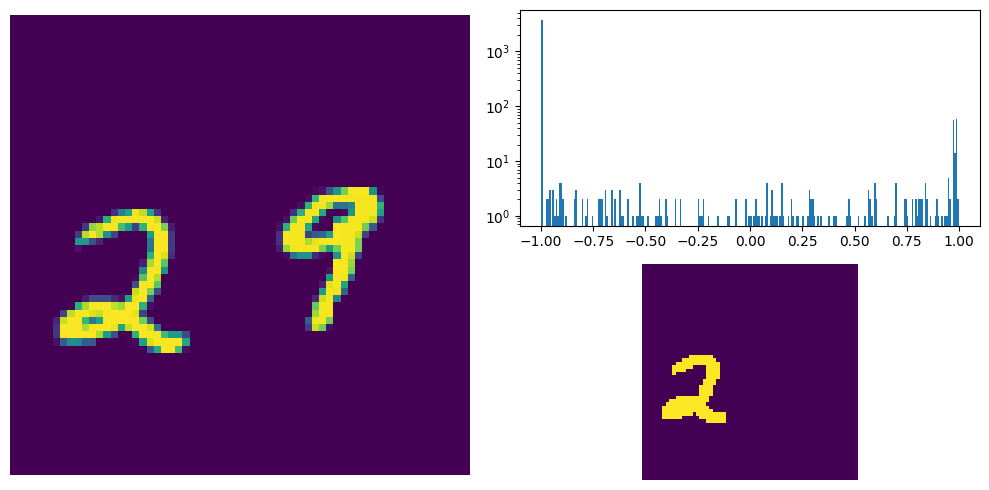

In [7]:
demo_trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])

demo_dataset = M2NISTData(combined=combined, segmented=segmented,
                          samp_size=20, samp_type='val', transform=demo_trans)

img, lab = demo_dataset.__getitem__(2)

print(type(img))
print(type(lab))
print(img.shape, lab.shape)

plt.figure(figsize=(10,5))
plt.subplot(2,2,(1,3))
plt.imshow(img[0])
plt.axis('off')

plt.subplot(2,2,2)
plt.hist(img.ravel(), bins=256)
plt.yscale('log')

plt.subplot(2,2,4)
plt.imshow(lab[2,...])
plt.axis('off')

plt.tight_layout()
plt.show()

# Training

In [32]:
# ------------------------------
# Define the Dice Loss for multi-class segmentation
# ------------------------------
class DiceLoss(nn.Module):
    """
    Computes the multi-class Dice loss.
    This implementation takes the raw logits (inputs) and the ground truth target masks 
    (with shape [B, H, W] and class indices) and returns the Dice loss.
    
    The error "one_hot is only applicable to index tensor" occurs if the target tensor 
    is not of the integer type. Thus, we ensure targets are converted to torch.long before applying one_hot.
    """
    def __init__(self, smooth=1e-4):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        Computes the Dice loss for multi-class segmentation without using one_hot encoding.
        
        Args:
            outputs: Tensor of shape [B, C, H, W], raw logits for each class.
            targets: Tensor of shape [B, H, W], ground truth with class indices.
            smooth: Smoothing factor to avoid division by zero.
            
        Returns:
            A scalar Dice loss.
            
        This function applies softmax to the model outputs to obtain class probabilities.
        Then, for each class it creates a binary mask by comparing the target indices with the class label.
        The dice score is computed as:
            dice = (2 * intersection + smooth) / (union + smooth),
        where intersection is the element-wise product between the predicted probability and the binary mask,
        and union is the sum of predicted probabilities and binary mask over the spatial dimensions.
        The final loss is the average of (1 - dice score) across all classes.
        """
        # Apply softmax to obtain probability maps for each class
        probs = F.softmax(inputs, dim=1)  # Shape: [B, C, H, W]
        
        num_classes = inputs.shape[1]
        dice_loss_sum = 0.0
        
        # For each class, compute the Dice loss without converting targets to one-hot
        for cls in range(num_classes):
            # Create binary mask for the current class: 1 where target equals current class, 0 elsewhere
            target_cls = (targets == cls).float()   # Shape: [B, H, W]
            
            # Get predicted probabilities for the current class
            pred_cls = probs[:, cls, :, :]            # Shape: [B, H, W]
            
            # Compute the intersection and union over spatial dimensions for each batch item
            intersection = (pred_cls * target_cls).sum(dim=(1,2))
            union = pred_cls.sum(dim=(1,2)) + target_cls.sum(dim=(1,2))
            
            # Calculate dice score per image in the batch
            dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
            
            # Dice loss for this class: average over the batch
            dice_loss_sum += (1 - dice_score).mean()
        
        # Average the dice loss across all classes
        return dice_loss_sum / num_classes


# ------------------------------
# Metric functions: Precision, Dice Score and IoU
# ------------------------------
def calculate_precision(pred, target, num_classes=10):
    """
    Calculate precision per class and return the average precision.
    
    Args:
      pred: Predicted segmentation map, tensor of shape [B, H, W].
      target: Ground truth segmentation map, tensor of shape [B, H, W].
      num_classes: Number of segmentation classes.
    Returns:
      Average precision over all classes.
    """
    precision_list = []
    for cls in range(num_classes):
        # Create a binary mask for current class in predictions and truth
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        tp = torch.sum((pred_cls & target_cls).float())
        fp = torch.sum((pred_cls & (~target_cls)).float())
        if (tp + fp) == 0:
            precision_cls = 0.0
        else:
            precision_cls = (tp / (tp + fp)).item()
        precision_list.append(precision_cls)
    return np.mean(precision_list)

def calculate_iou(pred, target, num_classes=10):
    """
    Calculate Intersection over Union (IoU) per class and return the average IoU.
    
    Args:
      pred: Predicted segmentation map, tensor of shape [B, H, W].
      target: Ground truth segmentation map, tensor of shape [B, H, W].
      num_classes: Number of segmentation classes.
    Returns:
      Average IoU over all classes.
    """
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = torch.sum((pred_cls & target_cls).float())
        union = torch.sum((pred_cls | target_cls).float())
        if union == 0:
            iou = 0.0
        else:
            iou = (intersection / union).item()
        iou_list.append(iou)
    return np.mean(iou_list)

def calculate_dice_score(pred, target, num_classes=10, smooth=1e-4):
    """
    Calculate the Dice score per class and return the average Dice score.
    
    Args:
      pred: Predicted segmentation map, tensor of shape [B, H, W].
      target: Ground truth segmentation map, tensor of shape [B, H, W].
      num_classes: Number of segmentation classes.
      smooth: Smoothing constant to avoid division by zero.
    Returns:
      Average Dice score over all classes.
    """
    dice_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = torch.sum(pred_cls * target_cls)
        dice = (2 * intersection + smooth) / (torch.sum(pred_cls) + torch.sum(target_cls) + smooth)
        dice_list.append(dice.item())
    return np.mean(dice_list)

# ------------------------------
# Helper function to update matplotlib plots dynamically
# ------------------------------
def update_plots(epochs, train_loss_history, val_loss_history, train_metric_history, val_metric_history):
    """
    Update matplotlib figures with training and validation loss & metrics.
    This function plots two panels: one for losses and one for metrics.
    """
    plt.clf()  # clear the current figure

    # Create a figure with two subplots (panels)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # First panel -- Loss curves for train and validation
    ax1.plot(range(1, epochs + 1), train_loss_history, 'b-', label="Train Loss")
    ax1.plot(range(1, epochs + 1), val_loss_history, 'r-', label="Validation Loss")
    ax1.set_title("Loss per Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)
    
    # Second panel -- Metrics: we plot Precision, Dice and IoU for validation
    # Here, train_metric_history and val_metric_history are dictionaries containing lists
    ax2.plot(range(1, epochs + 1), train_metric_history["precision"], 'b--', label="Train Precision")
    ax2.plot(range(1, epochs + 1), val_metric_history["precision"], 'b-', label="Val Precision")
    
    ax2.plot(range(1, epochs + 1), train_metric_history["dice"], 'g--', label="Train Dice")
    ax2.plot(range(1, epochs + 1), val_metric_history["dice"], 'g-', label="Val Dice")
    
    ax2.plot(range(1, epochs + 1), train_metric_history["iou"], 'm--', label="Train IoU")
    ax2.plot(range(1, epochs + 1), val_metric_history["iou"], 'm-', label="Val IoU")
    
    ax2.set_title("Metrics per Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Metric value")
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.pause(0.1)  # pause to update the plots

# ------------------------------
# Main training loop for semantic segmentation
# ------------------------------
def train_model(model, dataloaders, num_epochs=20, learning_rate=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    train_loader, val_loader = dataloaders[0], dataloaders[1]
    
    # Initialize the segmentation network, loss functions and optimizer
    
    # CrossEntropyLoss expects logits and target of shape [B, H, W] with class indices.
    ce_loss_fn = nn.CrossEntropyLoss()
    dice_loss_fn = DiceLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Variables to store history for plotting
    train_loss_history = []
    val_loss_history = []

    # Dictionaries to store metric history per epoch for train and validation
    train_metric_history = {"precision": [], "dice": [], "iou": []}
    val_metric_history = {"precision": [], "dice": [], "iou": []}

    # Enable interactive mode for matplotlib
    plt.ion()

    for epoch in range(1, num_epochs + 1):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Accumulators for training metrics
        running_precision = 0.0
        running_dice = 0.0
        running_iou = 0.0
        num_batches = 0
        
        start_time = time.time()
        
        # ------------------------------
        # Training Loop
        # ------------------------------
        for images, masks in train_loader:
            
            images = images.to(device)  # [B, 1, 64, 64]
            masks = masks.to(device)    # [B, 64, 64], class indices

            optimizer.zero_grad()
            outputs = model(images)     # [B, 10, 64, 64]
            
            # Compute Cross Entropy Loss (expects logits and ground truth mask)
            ce_loss = ce_loss_fn(outputs, masks)
            # Compute Dice Loss (requires combining outputs with ground truth)
            dice_loss = dice_loss_fn(outputs, masks)
            # Combine losses (you can add weights if needed)
            loss = ce_loss + dice_loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            num_batches += 1

            # For logging metrics in training, compute predictions
            preds = torch.argmax(outputs, dim=1)  # [B, 64, 64]
            running_precision += calculate_precision(preds, masks)
            running_dice += calculate_dice_score(preds, masks)
            running_iou += calculate_iou(preds, masks)
        
        # Average training loss and metrics
        avg_train_loss = running_loss / num_batches
        avg_train_precision = running_precision / num_batches
        avg_train_dice = running_dice / num_batches
        avg_train_iou = running_iou / num_batches
        
        train_loss_history.append(avg_train_loss)
        train_metric_history["precision"].append(avg_train_precision)
        train_metric_history["dice"].append(avg_train_dice)
        train_metric_history["iou"].append(avg_train_iou)
        
        # ------------------------------
        # Validation Loop
        # ------------------------------
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_batches = 0
        val_precision = 0.0
        val_dice = 0.0
        val_iou = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                ce_loss = ce_loss_fn(outputs, masks)
                dice_loss = dice_loss_fn(outputs, masks)
                loss = ce_loss + dice_loss
                val_loss += loss.item()
                val_batches += 1
                
                preds = torch.argmax(outputs, dim=1)  # [B, 64, 64]
                val_precision += calculate_precision(preds, masks)
                val_dice += calculate_dice_score(preds, masks)
                val_iou += calculate_iou(preds, masks)
            
        # Average validation loss and metrics
        avg_val_loss = val_loss / val_batches
        avg_val_precision = val_precision / val_batches
        avg_val_dice = val_dice / val_batches
        avg_val_iou = val_iou / val_batches
        
        val_loss_history.append(avg_val_loss)
        val_metric_history["precision"].append(avg_val_precision)
        val_metric_history["dice"].append(avg_val_dice)
        val_metric_history["iou"].append(avg_val_iou)
        
        elapsed = time.time() - start_time
        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                f"Train Precision: {avg_train_precision:.4f} | Val Precision: {avg_val_precision:.4f} | "
                f"Train Dice: {avg_train_dice:.4f} | Val Dice: {avg_val_dice:.4f} | "
                f"Train IoU: {avg_train_iou:.4f} | Val IoU: {avg_val_iou:.4f} | Time: {elapsed:.2f}s")
        
        # Update plots dynamically
        update_plots(epoch, train_loss_history, val_loss_history, train_metric_history, val_metric_history)

    # Close plotting when training is finished
    plt.ioff()
    plt.show()


In [33]:
train_model(model=net.UNetMini(1, 10),
            dataloaders=get_dataloaders(combined, segmented,
                                           train_samp_size=64,
                                           val_samp_size=32,
                                           batch_size=16))

Using device: cpu


RuntimeError: The size of tensor a (16) must match the size of tensor b (10) at non-singleton dimension 1

### Dummy training

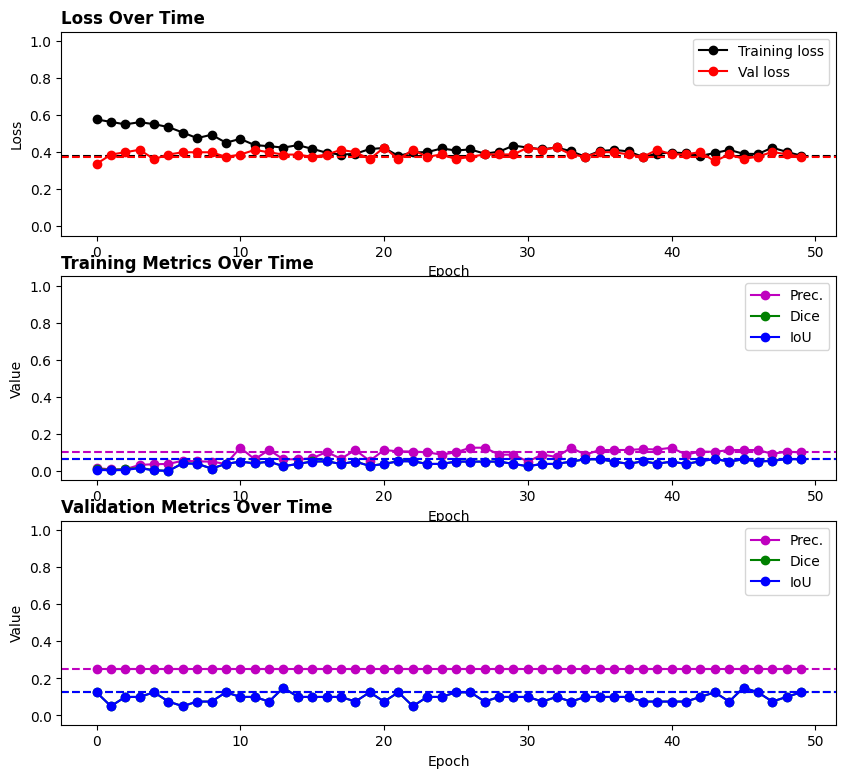

In [5]:
device = torch.device("cpu")  # "cuda:0" if torch.cuda.is_available() else 

# train_loader, val_loader = get_synth_dataloaders(train_samp_size=50, val_samp_size=10, batch_size=5)
# model = UNet(2)

train_loader, val_loader = get_dataloaders(combined, segmented,
                                           train_samp_size=32,
                                           val_samp_size=16,
                                           batch_size=4)
model = net.UNetMini(1, 10)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)


def calc_loss(pred, target, bce_weight=0.5):
    def dice_loss(pred, target, smooth=1e-6):
        pred = F.sigmoid(pred)
        pred = (pred > 0.75).float()

        # pred = torch.softmax(pred, dim=1)
        # target_one_hot = nn.functional.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()

        intersection = (pred * target).sum(dim=(0,2,3))
        union = pred.sum(dim=(0,2, 3)) + target.sum(dim=(0,2, 3))
        loss = 1. - 2.*((intersection + smooth) / (union + smooth))

        return loss.mean()
    
    def tversky_loss(pred, target, alpha=0.4, beta=0.6, smooth=1e-6):
        pred = F.sigmoid(pred)
        pred = (pred > 0.75).float()
        
        tp = (pred * target).sum(dim=(0, 2, 3))
        fp = (pred * (1 - target)).sum(dim=(0,2, 3))
        fn = ((1 - pred) * target).sum(dim=(0, 2, 3))

        tversky_loss = 1. - ((tp + smooth) / (tp + alpha*fp + beta*fn + smooth))

        return tversky_loss.mean()

    def iou_loss(pred, target, smooth=1e-6):
        pred = F.sigmoid(pred)
        pred = (pred > 0.75).float()

        intersection = (pred * target).sum(dim=(2,3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        iou_loss = (1. - (intersection + smooth) / (union + smooth))
        return iou_loss.mean()
    

    # entropy_loss = F.binary_cross_entropy_with_logits(pred, target)
    criterion = nn.CrossEntropyLoss()
    entropy_loss = criterion(pred, target)
    overlap_loss = tversky_loss(pred, target)

    loss = (entropy_loss * bce_weight) + (overlap_loss * (1 - bce_weight))

    return loss


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid без подальшого бінарного порогового переведення для диференційованості
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        intersection = (inputs * targets).sum(dim=1)
        dice = (2. * intersection + self.smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + self.smooth)
        loss = 1 - dice
        return loss.mean()


def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0.

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        train_batch_loss = loss_fn(pred, y)
        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()

        train_loss += train_batch_loss.item()*X.size(0)

    train_loss /= len(dataloader)
    return train_loss 

def validation_loop(dataloader, model, loss_fn):
    model.eval()
    val_loss = 0.

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        val_batch_loss = loss_fn(pred, y)
        val_loss += val_batch_loss.item()*X.size(0)

    val_loss /= len(dataloader)
    return val_loss


def overlap_metrics(pred, target, eps=1e-5):
    pred = F.sigmoid(pred)
    pred = (pred > 0.75).float()
    
    tp = (pred * target).sum(dim=(0, 2, 3))              # TP
    fp = (pred * (1 - target)).sum(dim=(0, 2, 3))        # FP
    fn = ((1 - pred) * target).sum(dim=(0, 2, 3))        # FN
    tn = ((1 - pred) * (1 - target)).sum(dim=(0, 2, 3))  # TN

    dice = (2*tp + eps) / (2*tp + fp + fn + eps)
    iou = (tp + eps) / (tp + fp + fn + eps)
    prec = (tp + eps) / (tp + fp + eps)
    # recall = (tp + eps) / (tp + fn + eps)
    # specificity = (tn + eps) / (tn + fp + eps)
    # pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)

    return [dice.mean(), iou.mean(), prec.mean()]

def print_training_progress_bar(iteration, total,loss_val, length=30):
    percent = f"{100 * (float(iteration+1) / float(total)):.1f}"
    filled_length = int(length * (iteration+1) // (total))
    bar = '█' * filled_length + '-' * (length - filled_length)
    print(f'\rEpoch {iteration+1}/{total}| LR:{loss_val[-1]} | Train loss:{loss_val[0]:.4f} | Val loss:{loss_val[1]:.4f}: |{bar}| {percent}%', end = '\r')
    if iteration == total: 
        print()

def update_plot(trin_list, val_list):
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=3, figsize=(10,9))

    ax[0].plot(trin_list[0], label='Training loss', marker='o', color='k')
    ax[0].axhline(trin_list[0][-1], linestyle='--', color='k')
    ax[0].plot(val_list[0], label='Val loss', marker='o', color='r')
    ax[0].axhline(val_list[0][-1], linestyle='--', color='r')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss Over Time', loc='left', fontweight="bold")
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].legend()

    ax[1].plot(trin_list[1]['Prec'], label='Prec.', marker='o', color='m')
    ax[1].axhline(trin_list[1]['Prec'][-1], linestyle='--', color='m')
    ax[1].plot(trin_list[1]['Dice'], label='Dice', marker='o', color='g')
    ax[1].axhline(trin_list[1]['Dice'][-1], linestyle='--', color='g')
    ax[1].plot(trin_list[1]['IoU'], label='IoU', marker='o', color='b')
    ax[1].axhline(trin_list[1]['IoU'][-1], linestyle='--', color='b')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Value')
    ax[1].set_title('Training Metrics Over Time', loc='left', fontweight="bold")
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].legend()

    ax[2].plot(val_list[1]['Prec'], label='Prec.', marker='o', color='m')
    ax[2].axhline(val_list[1]['Prec'][-1], linestyle='--', color='m')
    ax[2].plot(val_list[1]['Dice'], label='Dice', marker='o', color='g')
    ax[2].axhline(val_list[1]['Dice'][-1], linestyle='--', color='g')
    ax[2].plot(val_list[1]['IoU'], label='IoU', marker='o', color='b')
    ax[2].axhline(val_list[1]['IoU'][-1], linestyle='--', color='b')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Value')
    ax[2].set_title('Validation Metrics Over Time', loc='left', fontweight="bold")
    ax[2].set_ylim(-0.05, 1.05)
    ax[2].legend()

    plt.show()



train_loss_list = []
val_loss_list = []

train_metrics = {'IoU':[],
                 'Dice':[],
                 'Prec':[]}
val_metrics = {'IoU':[],
               'Dice':[],
               'Prec':[]}

n_epoch = 50
for e in range(n_epoch):

    # train_loss = train_loop(train_loader, model, calc_loss, optimizer)
    # train_loss_list.append(train_loss)

    # val_loss = validation_loop(val_loader, model, calc_loss)
    # val_loss_list.append(val_loss)


    # train loop
    model.train()
    train_loss = 0.

    for train_input, train_target in train_loader:
        train_input, train_target = train_input.to(device), train_target.to(device)
        train_pred = model(train_input)
        train_pred = train_pred.to(device)
        train_batch_loss = calc_loss(train_pred, train_target)

        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()
    
        train_loss += train_batch_loss.item()

    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    train_om = overlap_metrics(pred=train_pred, target=train_target)
    train_metrics['Dice'].append(train_om[0].detach().numpy() / len(train_loader))
    train_metrics['IoU'].append(train_om[1].detach().numpy() / len(train_loader))
    train_metrics['Prec'].append(train_om[2].detach().numpy() / len(train_loader))

    # scheduler.step()


    # validation loop
    model.eval()
    val_loss = 0.

    for val_input, val_target in val_loader:
        val_input, val_target = val_input.to(device), val_target.to(device)

        val_pred = model(val_input)
        val_batch_loss = calc_loss(pred=val_pred, target=val_target)
        val_loss += val_batch_loss.item()

    val_loss /= len(val_loader)
    val_loss_list.append(val_loss)
    val_om = overlap_metrics(pred=val_pred, target=val_target)
    val_metrics['Dice'].append(val_om[0].detach().numpy() / len(val_loader))
    val_metrics['IoU'].append(val_om[1].detach().numpy() / len(val_loader))
    val_metrics['Prec'].append(val_om[2].detach().numpy() / len(val_loader))

    update_plot([train_loss_list, train_metrics], [val_loss_list, val_metrics])
    print_training_progress_bar(iteration=e, total=n_epoch, loss_val=[train_loss, val_loss, optimizer.param_groups[0]['lr']])


torch.save(model.state_dict(), '2608_mnist_unetmini_02.pt')

### External training

In [ ]:
class TrainRun():
    def __init__(self, unet_model, dataloaders_dict,
                 n_epoch=5, n_class=10, n_test=2, loss_type='dice', loss_bce_weight=0.5, init_lr=1e-3):
        self.n_class = n_class
        self.n_epoch = n_epoch
        self.n_test = n_test

        self.loss_type = loss_type
        self.loss_bce_weight = loss_bce_weight
        self.init_lr = init_lr

        self.dataloaders_dict = dataloaders_dict

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = unet_model(self.n_class).to(self.device)

        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.init_lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.1)


    @staticmethod
    def calc_loss(pred, target, metrics, bce_weight=0.5, loss_type='dice'):
        # https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou
        def dice_loss(pred, target, smooth=1.):
            pred = pred.contiguous()
            target = target.contiguous()

            intersection = (pred * target).sum(dim=2).sum(dim=2)
            dice_loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
            
            return dice_loss.mean()

        def iou_loss(pred, traget, smooth=1.):
            intersection = (target * pred).sum(dim=2).sum(dim=2)
            iou_loss = (1. - (intersection + smooth) / (target.sum(dim=2).sum(dim=2) + pred.sum(dim=2).sum(dim=2) - intersection + smooth))

            return iou_loss.mean()

        def overlap_metrics(pred, target, eps=1e-5):
            pred = pred.contiguous()
            target = target.contiguous()

            # metrics
            tp = torch.sum(pred * target)  # TP
            fp = torch.sum(pred * (1 - target))  # FP
            fn = torch.sum((1 - pred) * target)  # FN
            tn = torch.sum((1 - pred) * (1 - target))  # TN

            pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
            dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
            precision = (tp + eps) / (tp + fp + eps)
            recall = (tp + eps) / (tp + fn + eps)
            specificity = (tn + eps) / (tn + fp + eps)
            iou = (tp + eps) / (tp + fp + fp + eps)

            return [pixel_acc, dice, precision, recall, specificity, iou]
        
        bce = F.binary_cross_entropy_with_logits(pred, target)

        pred = F.sigmoid(pred)

        if loss_type == 'dice':
            overlap_loss = dice_loss(pred, target)
        elif loss_type == 'iou':
            overlap_loss = iou_loss(pred, target)

        loss = bce * bce_weight + overlap_loss * (1 - bce_weight)

        o_m = overlap_metrics(pred, target)

        metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
        metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
        metrics['overlap_loss'] += overlap_loss.data.cpu().numpy() * target.size(0)
        metrics['Dice'] += o_m[1].data.cpu().numpy() * target.size(0)
        metrics['IOU'] += o_m[5].data.cpu().numpy() * target.size(0)
        metrics['prec'] += o_m[2].data.cpu().numpy() * target.size(0)
        # metrics['px_acc'] += o_m[0].data.cpu().numpy() * target.size(0)
        # metrics['recall'] += o_m[3].data.cpu().numpy() * target.size(0)
        # metrics['spec'] += o_m[4].data.cpu().numpy() * target.size(0)

        return loss, metrics


    @staticmethod
    def print_metrics(metrics, epoch_samples, phase):
        outputs = []
        for k in metrics.keys():
            outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        print("{}: {}".format(phase, " | ".join(outputs)))

    
    def train_model(self):
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
        self.best_loss = 1e10

        self.train_loss_list = []
        self.val_loss_list = []

        self.train_px_acc_list = []
        self.val_px_acc_list = []

        self.train_prec_list = []
        self.val_prec_list = []

        train_start_time = time.time()

        for epoch in range(self.n_epoch):
            print('== Epoch {}/{} =='.format(epoch, self.n_epoch - 1))
            print('-' * 15)

            epoch_start_time = time.time()

            # Each epoch has a training and validation phase
            for phase in ['trn', 'val']:
                if phase == 'trn':
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()  # Set model to evaluate mode

                metrics = defaultdict(float)
                epoch_samples = 0

                for inputs, labels in self.dataloaders_dict[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'trn'):
                        outputs = self.model(inputs)
                        outputs = F.sigmoid(outputs)
                        loss, metrics = self.calc_loss(outputs, labels, metrics,
                                                       loss_type=self.loss_type,
                                                       bce_weight=self.loss_bce_weight)

                        # backward + optimize only if in training phase
                        if phase == 'trn':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

                if phase == 'trn':
                    self.scheduler.step()
                    for param_group in self.optimizer.param_groups:
                        print("LR", param_group['lr'])
                
                if phase == 'trn':
                    self.train_loss_list.append(metrics['loss'] / epoch_samples)
                    self.train_px_acc_list.append(metrics['IOU'] / epoch_samples)
                    self.train_prec_list.append(metrics['prec'] / epoch_samples)
                else:
                    self.val_loss_list.append(metrics['loss'] / epoch_samples)
                    self.val_px_acc_list.append(metrics['IOU'] / epoch_samples)
                    self.val_prec_list.append(metrics['prec'] / epoch_samples)

                self.print_metrics(metrics, epoch_samples, phase)
                epoch_loss = metrics['loss'] / epoch_samples

                # deep copy the model
                if phase == 'val' and epoch_loss < self.best_loss:
                    print("saving best model")
                    best_loss = epoch_loss
                    self.best_model_wts = copy.deepcopy(self.model.state_dict())

            time_elapsed = time.time() - epoch_start_time
            print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
        total_time_elapsed = time.time() - train_start_time 
        print('Best val loss: {:4f}, total train time {:.0f}m {:.0f}s'.format(best_loss, total_time_elapsed // 60, time_elapsed % 60))

        # load best model weights
        self.model.load_state_dict(self.best_model_wts)


    def exexute_train(self):
        self.train_model()

        # metrics plot
        plt.figure(figsize=(10,4))
        plt.plot(self.train_loss_list, label='train loss',
                 marker='o', color='k')
        plt.plot(self.val_loss_list, label='val loss',
                 marker='o', linestyle='--', color='k')

        plt.plot(self.train_prec_list, label='train prec',
                 marker='v', color='b')
        plt.plot(self.val_prec_list, label='val prec',
                 marker='v', linestyle='--', color='b')
        
        plt.plot(self.train_px_acc_list, label='train IOU',
                 marker='v', color='g')
        plt.plot(self.val_px_acc_list, label='val IOU',
                 marker='v', linestyle='--', color='g')

        plt.xticks(range(len(self.train_loss_list)))
        plt.xlabel('epoch')
        plt.ylabel('value')
        plt.legend()
        plt.show


    def execute_external_train(self):
        self.model, self.metrics_list = train_model_externally(model=self.model,
                                                                dat_load=self.dataloaders_dict,
                                                                optimizer=self.optimizer,
                                                                scheduler=self.scheduler,
                                                                num_epochs=self.n_epoch)
        
        # metrics plot
        plt.figure(figsize=(10,4))
        plt.plot(self.metrics_list[0], label='train loss',
                 marker='o', color='k')
        plt.plot(self.metrics_list[1], label='val loss',
                 marker='o', linestyle='--', color='k')

        plt.plot(self.metrics_list[4], label='train prec',
                 marker='v', color='b')
        plt.plot(self.metrics_list[5], label='val prec',
                 marker='v', linestyle='--', color='b')
        
        plt.plot(self.metrics_list[2], label='train IOU',
                 marker='v', color='g')
        plt.plot(self.metrics_list[3], label='val IOU',
                 marker='v', linestyle='--', color='g')

        plt.xticks(range(len(self.train_loss_list)))
        plt.xlabel('epoch')
        plt.ylabel('value')
        plt.legend()
        plt.show

# Testing

### Digits data

In [6]:
demo_trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])

test_dataset = M2NISTData(combined=combined, segmented=segmented,
                          samp_size=5000, samp_type='trn', transform=demo_trans)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=True)

test_inputs, test_labels = next(iter(test_dataloader))
print(test_labels.shape)

torch.Size([5, 10, 64, 64])


(5, 10, 64, 64)


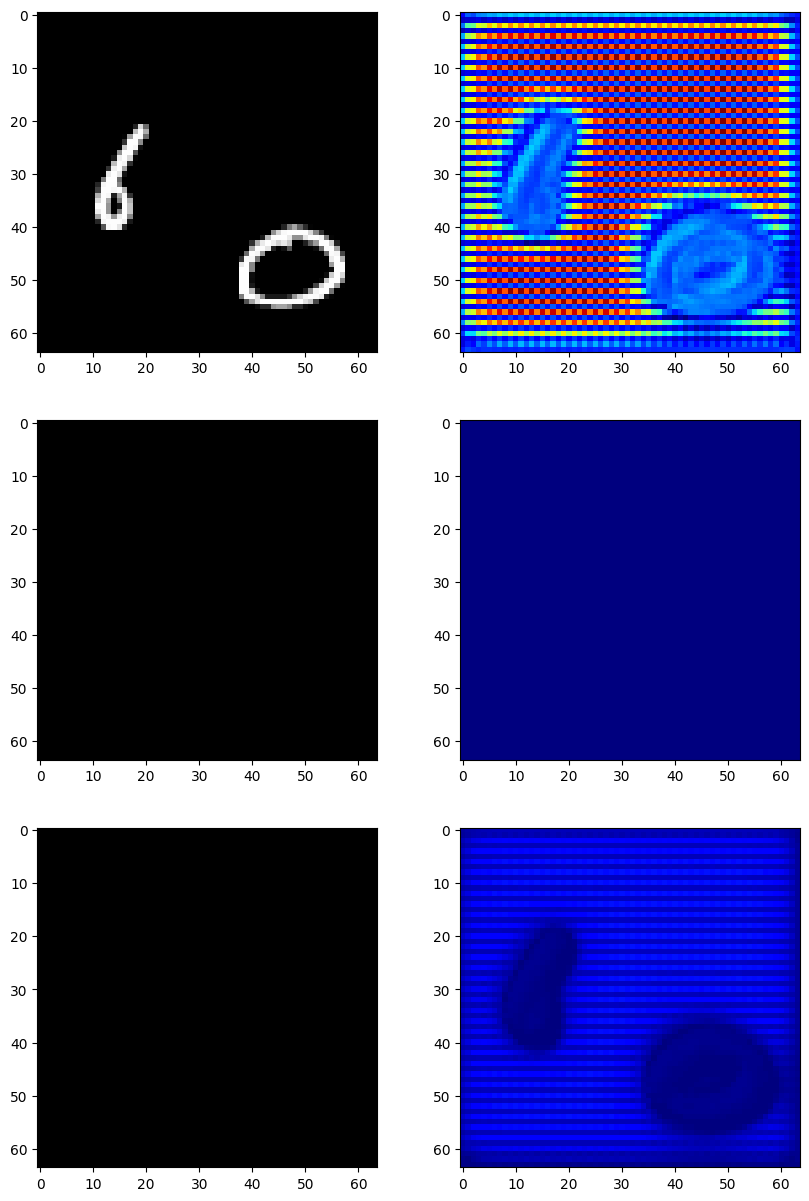

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_inputs = test_inputs.to(device)

model.eval()
test_pred = model(test_inputs)

test_pred = F.relu6(test_pred)
# test_pred = torch.softmax(test_pred, dim=1)
test_pred = test_pred.data.cpu().numpy()
test_pred_mask = test_pred > 0.95
print(test_pred.shape)


i = 0
one_lab, two_lab = 8, 9
 
fig, ax = plt.subplots(ncols=2,nrows=3, figsize=(10,15))
ax[0,0].imshow(test_inputs[i,0], cmap='Greys_r')
ax[0,1].imshow(np.sum(test_pred[i], axis=0), cmap='jet')
# ax[0,1].imshow(test_pred[i,-1], cmap='jet', vmin=0)
ax[1,0].contour(test_pred_mask[i,one_lab], levels=[0.5], cmap='Reds_r')
ax[1,0].imshow(test_labels[i,one_lab], cmap='Greys_r')
ax[2,0].contour(test_pred_mask[i,two_lab], levels=[0.5], cmap='Reds_r')
ax[2,0].imshow(test_labels[i,two_lab], cmap='Greys_r')
ax[1,1].imshow(test_pred[i,one_lab], cmap='jet', vmin=0, vmax=6)
ax[2,1].imshow(test_pred[i,two_lab], cmap='jet', vmin=0, vmax=6)